# ASR evaluation
we perform subjective evaluation based on 
1. CER/WER by strong ASR
2. estimated SI-SNR
The dataset includes "clean"(AISHELL), "noisy"(wild V2S), "processed"(V2S_tmp)

In [1]:
import scipy.io.wavfile as wavfile
import librosa
import os
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt


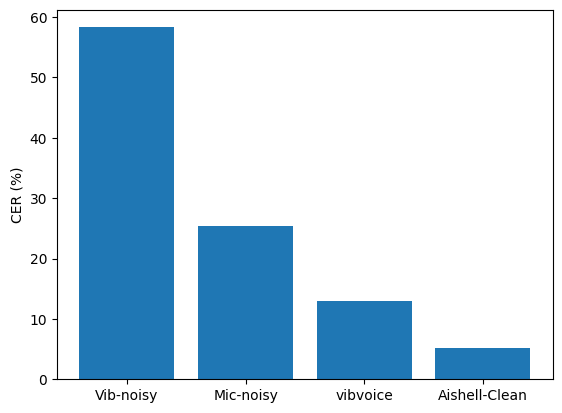

In [17]:
# Result
text = ['Vib-noisy', 'Mic-noisy', 'vibvoice', 'Aishell-Clean']
data = [58.32, 25.4, 12.93, 5.14]
plt.bar(range(len(text)), data)
plt.ylabel('CER (%)')
plt.xticks(range(len(text)), text)
plt.show()

In [2]:
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks

inference_16k_pipline = pipeline(
    task=Tasks.auto_speech_recognition,
    model='damo/speech_paraformer_asr_nat-aishell1-pytorch', device='gpu')

rec_result = inference_16k_pipline(audio_in='https://isv-data.oss-cn-hangzhou.aliyuncs.com/ics/MaaS/ASR/test_audio/asr_example_zh.wav')
print(rec_result)

2023-09-09 14:05:27,469 - modelscope - INFO - PyTorch version 1.13.0 Found.
2023-09-09 14:05:27,470 - modelscope - INFO - Loading ast index from /home/lixing/.cache/modelscope/ast_indexer
2023-09-09 14:05:27,485 - modelscope - INFO - Loading done! Current index file version is 1.8.4, with md5 bc2412af0ceee67320f5157c651de533 and a total number of 902 components indexed
2023-09-09 14:05:29,106 - modelscope - INFO - Model revision not specified, use the latest revision: v1.1.8
2023-09-09 14:05:29,571 - modelscope - INFO - initiate model from /home/lixing/.cache/modelscope/hub/damo/speech_paraformer_asr_nat-aishell1-pytorch
2023-09-09 14:05:29,571 - modelscope - INFO - initiate model from location /home/lixing/.cache/modelscope/hub/damo/speech_paraformer_asr_nat-aishell1-pytorch.
2023-09-09 14:05:29,572 - modelscope - INFO - initialize model from /home/lixing/.cache/modelscope/hub/damo/speech_paraformer_asr_nat-aishell1-pytorch
2023-09-09 14:05:29,574 - modelscope - WARNING - No preproces

{'text': '欢迎大家来体验打磨愿推出的语音识别模型'}


In [15]:
'''
prepare processed data into _tmp folder
1. separate to 1-st channel (vibration) or 2-nd channel (microphone)
'''

new_rate = 16000
dataset = '../V2S/'
dataset_target = '../V2S_tmp/'
for speaker in os.listdir(dataset):
    if not os.path.exists(dataset_target + speaker):
        os.mkdir(dataset_target + speaker)
    for date in os.listdir(dataset + speaker):
        print(speaker, date)
        if not os.path.exists(dataset_target + speaker + "/" + date):
            os.mkdir(dataset_target + speaker + "/" + date)
        for wav in tqdm(os.listdir(dataset + speaker + "/" + date)):
            if wav[-3:] != "wav":
                shutil.copy(dataset + speaker + "/" + date + "/" + wav, dataset_target + speaker + "/" + date + "/" + wav)
                continue
            path = dataset + speaker + "/" + date + "/" + wav
            data, sample_rate = librosa.load(path, mono=False, sr=None)
            samples = round(len(data) * float(new_rate) / sample_rate)
            new_data = librosa.resample(data[1], orig_sr=sample_rate, target_sr=new_rate, scale=True)
            wavfile.write(dataset_target + speaker + "/" + date + "/" + wav, new_rate, new_data.T)

Bian_Chen 2023-09-07


100%|██████████| 75/75 [00:00<00:00, 120.63it/s]


Bowen_Zheng 2023-09-07


100%|██████████| 79/79 [00:00<00:00, 2283.16it/s]


Bufang_Yang 2023-09-05


100%|██████████| 144/144 [00:00<00:00, 1786.84it/s]


Sitong_Cheng 2023-09-07


100%|██████████| 98/98 [00:00<00:00, 2301.85it/s]


Lixing_He 2023-09-05


100%|██████████| 135/135 [00:00<00:00, 1942.83it/s]


In [4]:
'''
evaluation 
python inference.py
'''
data = '../V2S_tmp/'
hypotheses = []
references = []
speaker_whitelist = ['Bufang_Yang', 'Lixing_He']
date_whitelist = ['2023-09-05', '2023-09-07']
for speaker in os.listdir(data):
    if speaker not in speaker_whitelist:
        continue
    directory = os.path.join(data, speaker)
    for date in os.listdir(directory):
        if date not in date_whitelist:
            continue
        directory_date = os.path.join(directory, date)
        labels = os.path.join(directory_date, 'labels.txt')
        labels = open(labels, 'r').readlines()
        for label in tqdm(labels):
            l = label.strip().split(' ')
            file = l[0]
            text = ''.join(l[1:])
            file = os.path.join(directory_date, file+'.wav')
            try: 
                rec_result = inference_16k_pipline(audio_in=file,)
                hypotheses.append(rec_result['text'])
                references.append(text)
            except:
                pass
import jiwer
wer = jiwer.cer(hypotheses, references)
print(f"CER: {wer * 100:.2f} %")   

  0%|          | 0/143 [00:00<?, ?it/s]2023-09-09 14:06:23,897 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:23,954 - modelscope - INFO - Computing the result of ASR ...
2023-09-09 14:06:23,955 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:23,979 - modelscope - INFO - Computing the result of ASR ...
2023-09-09 14:06:23,980 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:24,007 - modelscope - INFO - Computing the result of ASR ...
  2%|▏         | 3/143 [00:00<00:05, 26.89it/s]2023-09-09 14:06:24,009 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:24,034 - modelscope - INFO - Computing the result of ASR ...
2023-09-09 14:06:24,035 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:24,056 - modelscope - INFO - Computing the result of ASR ...
2023-09-09 14:06:24,057 - modelscope - INFO - Decoding with wav files ...
2023-09-09 14:06:24,085 - modelscope - INFO - Computing the result of ASR ...
20

CER: 13.26 %


In [14]:
'''
evaluation for estimated SISNR
python inference.py
'''
from speechbrain.pretrained.interfaces import SNREstimator as snrest
import torch
import torchaudio

# 3- Estimate the performance
snr_est_model = snrest.from_hparams(source="speechbrain/REAL-M-sisnr-estimator",savedir='pretrained_models/REAL-M-sisnr-estimator')
# snrhat = snr_est_model.estimate_batch(mix, est_sources)
# print(snrhat) # Estimates are in dB / 10 (in the range 0-1, e.g., 0 --> 0dB, 1 --> 10dB)

mix_data = '../V2S/'
data = '../V2S_tmp/'
speaker_whitelist = ['Bufang_Yang', 'Lixing_He']
date_whitelist = ['2023-09-05', '2023-09-07']
for speaker in os.listdir(data):
    if speaker not in speaker_whitelist:
        continue
    directory = os.path.join(data, speaker)
    for date in os.listdir(directory):
        if date not in date_whitelist:
            continue
        directory_date = os.path.join(directory, date)
        labels = os.path.join(directory_date, 'labels.txt')
        labels = open(labels, 'r').readlines()
        for label in tqdm(labels):
            l = label.strip().split(' ')
            file = l[0]
            text = ''.join(l[1:])
            file = os.path.join(directory_date, file+'.wav')
            est_source, fs = torchaudio.load(file)
            # mix_file = file.replace(data, mix_data)
            # mix, fs = torchaudio.load(mix_file)
            # mix = mix[1:, :]
            # est_source *= mix.max() / est_source.max()
            # est_noise = mix - est_source
            # est_sources = torch.stack([est_source, est_noise], dim=-1)

            est_sources = est_source[:, :, None].repeat(1, 1, 2)
            mix = est_source * 2
            # fig, axs = plt.subplots(2)
            # axs[0].plot(mix[0, :])
            # axs[1].plot(est_sources[0, :])
            # plt.show()
            snrhat = snr_est_model.estimate_batch(mix, est_sources)
            print(snrhat)
            break


  0%|          | 0/143 [00:00<?, ?it/s]


tensor([0.4867, 0.4867])


  0%|          | 0/134 [00:00<?, ?it/s]

tensor([1.1396, 1.1395])


In [ ]:
'''
fair evaluation - no noise
'''
data = '../ASR/aishell'
hypotheses = []
references = []
labels = '../ASR/aishell_transcript_v0.8.txt'
labels = open(labels, 'r').readlines()
for label in tqdm(labels):
    l = label.strip().split(' ')
    name = l[0]
    text = ''.join(l[1:])
    S = int(name[7:7+4])
    if S <= 723:
        dataset = 'aishell-train'
        continue
    elif S <= 763:
        dataset = 'aishell-dev'
        continue
    else:
        dataset = 'aishell-test' 
    file = os.path.join(data, dataset, name[6:6+5], name + '.wav')   
    rec_result = inference_16k_pipline(audio_in=file,)
    hypotheses.append(rec_result['text'])
    references.append(text)
import jiwer
wer = jiwer.cer(hypotheses, references)
print(f"CER: {wer * 100:.2f} %")   